<a href="https://colab.research.google.com/github/chloeamar/HackaSthon/blob/main/Base_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Plan: 

0. Importations
1. Data Preprocessing
2. Exploration et Statistiques Descriptives 
3. Deep Learning



# 0. Importations

Il faut créer sur votre drive un dossier "Colab Notebooks" et y mettre la base de donnée "Base_finale_clean.csv" directement

In [ ]:
#Accès au drive

from google.colab import drive
drive.mount('/content/drive')
import os 

root_dir = "/content/drive/MyDrive/"
project_folder = "Colab Notebooks/"

os.chdir(root_dir + project_folder)

#Manipulations des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
!pip install nlp &> /dev/null
import nlp
from wordcloud import WordCloud

#Data Preprocessing 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from re import compile
import string

#Deep learning 

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.neural_network import MLPClassifier

#BERT 

import tensorflow_hub as hub
!pip3 install tensorflow_text &> /dev/null
import tensorflow_text as text
from keras import backend as K

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
base_finale = './Base_finale_clean.csv'
df_base_finale = pd.read_csv(base_finale)
df_base_finale.count()

libelle               7184
reference             3750
annee                 7184
criticite             7184
origine               7184
date_envoi_rapport    7184
direction             7184
Recommandation        7184
dtype: int64

In [ ]:
df_base_finale.head()

,libelle,reference,annee,criticite,origine,date_envoi_rapport,direction,Recommandation
0,2010-002 - Financement du SPT et du LS,CFF-2010-MI001-R001,2010,P2,CFF,01/06/2010,Direction Générale,Commissionnement : La convention signée avec ...
1,2010-020 - SOCFIM,CFF-2010-MI002-R001,2010,P2,CFF,01/06/2010,Socfim,Séparation des fonctions : Attribuer au back-...
2,2010-020 - SOCFIM,CFF-2010-MI002-R002,2010,P3,CFF,01/06/2010,Socfim,Indicateur de gestion : Etablir des statistiq...
3,2010-020 - SOCFIM,CFF-2010-MI002-R003,2010,P2,CFF,01/06/2010,Socfim,Procédures BO : Rédiger des procédures de BO ...
4,2010-080 - CAC : Arrêté des comptes 2009 du CFF,CFF-2010-MI004-R001,2010,P3,CFF,01/06/2010,Inspection Générale,Calcul du risque immobilier : pour les PVH c...


In [ ]:
df_all = df_base_finale.copy()

df_all_nodup = df_all[(~df_all['reference'].duplicated()) | df_all['reference'].isna()]
df_all_nodup.count()

libelle               7184
reference             3750
annee                 7184
criticite             7184
origine               7184
date_envoi_rapport    7184
direction             7184
Recommandation        7184
dtype: int64

In [ ]:
df_all_nodup.head()

,libelle,reference,annee,criticite,origine,date_envoi_rapport,direction,Recommandation
0,2010-002 - Financement du SPT et du LS,CFF-2010-MI001-R001,2010,P2,CFF,01/06/2010,Direction Générale,Commissionnement : La convention signée avec ...
1,2010-020 - SOCFIM,CFF-2010-MI002-R001,2010,P2,CFF,01/06/2010,Socfim,Séparation des fonctions : Attribuer au back-...
2,2010-020 - SOCFIM,CFF-2010-MI002-R002,2010,P3,CFF,01/06/2010,Socfim,Indicateur de gestion : Etablir des statistiq...
3,2010-020 - SOCFIM,CFF-2010-MI002-R003,2010,P2,CFF,01/06/2010,Socfim,Procédures BO : Rédiger des procédures de BO ...
4,2010-080 - CAC : Arrêté des comptes 2009 du CFF,CFF-2010-MI004-R001,2010,P3,CFF,01/06/2010,Inspection Générale,Calcul du risque immobilier : pour les PVH c...


# 1. Data Preprocessing

***Suppression des stopwords, des sigles et entités, de la ponctuation, des chiffres. Transformation des majuscules en minuscules. Pas de lemmatization.***

In [ ]:
df_reco_all = df_all_nodup.copy()
# stop words et ponctuation
stopw = set(stopwords.words('french'))
punc = string.punctuation
autres = ['cff','bpce','itce','cnce', 'cneti','cfcal','cfb','cfg','natixis','ixis','cfhl','cfi','scf','afin']

stop_s=list(stopw) + list(punc) + autres

# expressions régulières
regex1 = compile(r'\W|\d+') # caractère non alphanumérique
regex2 = compile(r'\b\d+\b')  # chiffre ou nombre
regex3 = compile(r'\b[a-z]\b') #caractère de a à z 

# lower case
df_reco_all['reco'] = df_reco_all['Recommandation'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Suppression ponctuation et stop words, puis des chiffres ou des mots d'une lettre
df_reco_all.reco = df_reco_all.reco.apply(lambda x: regex1.sub(" ",x))
df_reco_all.reco = df_reco_all.reco.apply(lambda x: regex2.sub(" ",x))
df_reco_all.reco = df_reco_all.reco.apply(lambda x: regex3.sub(" ",x))

df_reco_all.reco = df_reco_all.reco.apply(lambda x: " ".join(x for x in x.split() if x not in stop_s))

In [ ]:
df_reco = df_reco_all[['annee','direction','origine','criticite','reco']]
df_reco.count()


df_reco.head()

,annee,direction,origine,criticite,reco
0,2010,Direction Générale,CFF,P2,commissionnement convention signée régissant n...
1,2010,Socfim,CFF,P2,séparation fonctions attribuer back office tâc...
2,2010,Socfim,CFF,P3,indicateur gestion etablir statistiques suivi ...
3,2010,Socfim,CFF,P2,procédures bo rédiger procédures bo faisant re...
4,2010,Inspection Générale,CFF,P3,calcul risque immobilier pvh constituer histor...


***On créer une table de recommandation annexe qui regroupe les niveaux de criticités P1 et P2.***

In [ ]:
df_reco_P1P2 = df_reco
df_reco_P1P2 = df_reco_P1P2.replace({'P1': 'P1P2', 'P2': 'P1P2'})

In [ ]:
df_reco_P1P2.head()

,annee,direction,origine,criticite,reco
0,2010,Direction Générale,CFF,P1P2,commissionnement convention signée régissant n...
1,2010,Socfim,CFF,P1P2,séparation fonctions attribuer back office tâc...
2,2010,Socfim,CFF,P3,indicateur gestion etablir statistiques suivi ...
3,2010,Socfim,CFF,P1P2,procédures bo rédiger procédures bo faisant re...
4,2010,Inspection Générale,CFF,P3,calcul risque immobilier pvh constituer histor...


# 2. Statistiques Descriptives

## Statistiques globales

### Nombre de recommandations totales et niveau de criticité

,reco
criticite,
P1,214
P2,2770
P3,4200


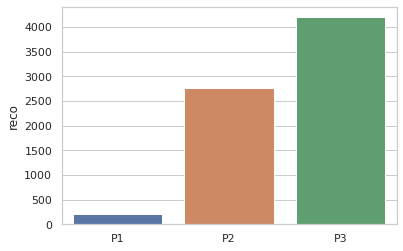

In [ ]:
sns.set_theme(style="whitegrid")

sns.barplot(x = ['P1','P2','P3'], 
                y = df_reco[['criticite','reco']].groupby('criticite')['reco'].count(), 
                data = df_reco[['criticite','reco']])

df_reco[['criticite','reco']].groupby('criticite').count()

***On remarque que la criticité P1 est la criticité la moins représentée, puisqu'il y a 8.5 fois plus de recommandations P2 comparé à P1, et 12.5 fois plus de recommandations P3 comparé à P1.*** 

***On rappelle que P1 est le niveau de criticité le plus élevé.*** 

### Évolution du nombre de recommandations par an

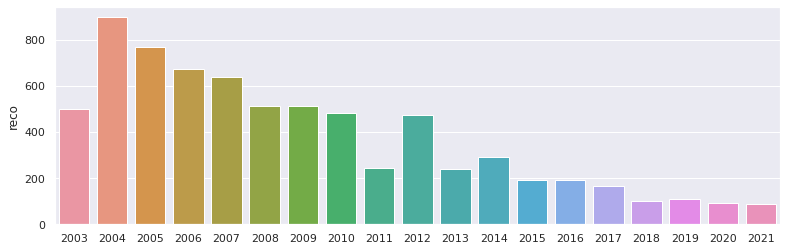

In [ ]:
sns.set(rc={'figure.figsize':(13,4)})

sns.barplot(x = [i for i in range (2003,2022)], 
                y = df_reco[['annee','reco','criticite']].groupby('annee')['reco'].count(),
                )


***On remarque qu'avec le temps, le nombre de recommandations par an a beaucoup diminué***

### Analyse des niveaux de criticité par an

In [ ]:
#Élaboration d'un dataframe qui regroupe les recommandations par an, pour s'intéresser à l'évolution des criticités chaque année


annees = [i for i in range (2003,2022)]
L = []
for i in range (len(annees)):
    L.append( [annees[i]])

for i in range (len(L)):
    L[i].append(0)
    L[i].append(0)
    L[i].append(0)

for i in range (len(df_reco)):
    for j in range (len(L)):
        if df_reco.iloc[i]["annee"] == L[j][0]:
            if df_reco.iloc[i]["criticite"] == "P1":
                L[j][1] += 1
            elif df_reco.iloc[i]["criticite"] == "P2":
                L[j][2] += 1
            else: 
                L[j][3] += 1

cricites_par_annee = pd.DataFrame (L, columns = ['annee','P1','P2','P3'])
cricites_par_annee.head()

,annee,P1,P2,P3
0,2003,10,128,363
1,2004,5,262,632
2,2005,9,276,484
3,2006,24,237,414
4,2007,25,198,417


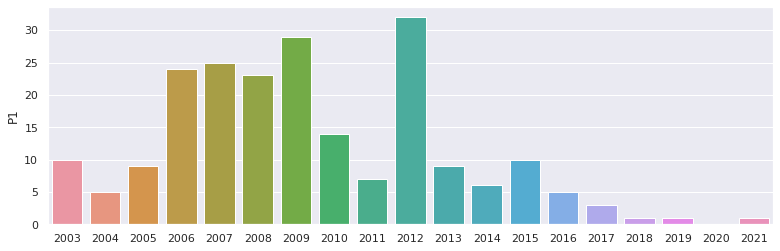

In [ ]:
sns.set(rc={'figure.figsize':(13,4)})

sns.barplot(x = [i for i in range (2003,2022)], 
                y = 'P1',
                data = cricites_par_annee)



***On remarque qu'une explosion des cas de criticités P1 a eu lieu en 2009, l'année suivant la crise des subprimes. Potentiellement dû à un problème de méthode consistant à classer les recos du superviseur en catégorie P1/P2. Exclure les recos concernant cette mission.***

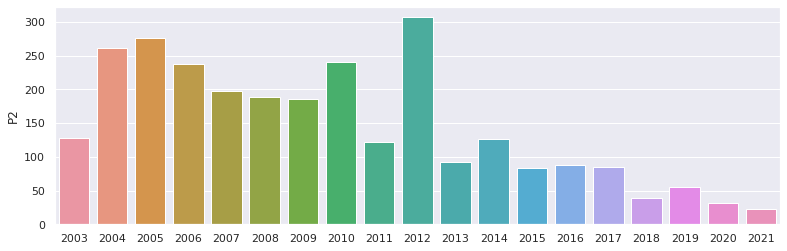

In [ ]:
sns.set(rc={'figure.figsize':(13,4)})

sns.barplot(x = [i for i in range (2003,2022)], 
                y = 'P2',
                data = cricites_par_annee)

***On remarque que la moyenne du nombre de cas de criticités P2 de l'année 2003 à 2012 est beaucoup plus élevée que celle de l'année 2013 à 2021.***

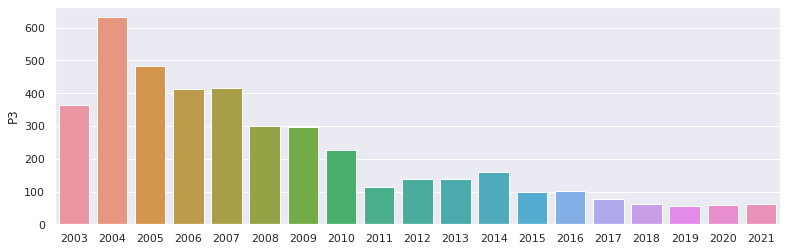

In [ ]:
sns.set(rc={'figure.figsize':(13,4)})

sns.barplot(x = [i for i in range (2003,2022)], 
                y = 'P3',
                data = cricites_par_annee)

## Statistiques sur les mots

### Distribution du nombre de mots

In [ ]:
Xlist = np.array(df_reco['reco'].tolist())
List_words_by_reco = []
for i in range (len(Xlist)): 
    words_reco_i = Xlist[i].split()
    List_words_by_reco.append(words_reco_i)

Words_number_by_reco = []
for i in range (len(List_words_by_reco)):
    Words_number_by_reco.append(len(List_words_by_reco[i]))



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


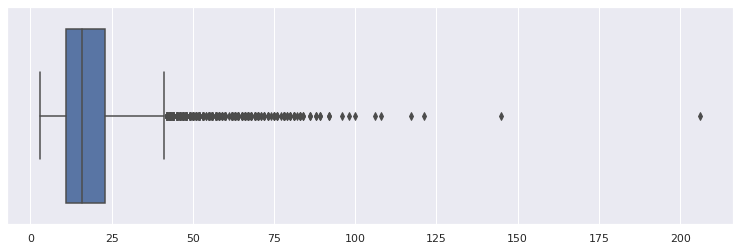

In [ ]:
sns.boxplot(Words_number_by_reco)

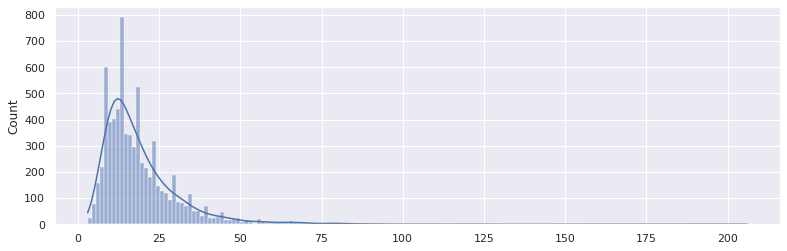

In [ ]:
sns.histplot(Words_number_by_reco, kde = True)

### Nuage de mots en fonction de l'année des recommandations

In [ ]:
text = ""
for i in range (len(df_reco)):
    text += "".join(df_reco.iloc[i]['reco'])



In [ ]:
text = ""
for i in range (len(df_reco_all)):
    text += "".join(df_reco_all.iloc[i]['reco'])


print(text.split())

['commissionnement', 'convention', 'signée', 'régissant', 'notamment', 'commissionnement', 'titre', 'prêts', 'structurés', 'plus', 'valide', 'depuis', 'signer', 'nouvelle', 'conventionséparation', 'fonctions', 'attribuer', 'back', 'office', 'tâches', 'relatives', 'ajustements', 'positions', 'partenaires', 'encore', 'exécutées', 'comptabilitéindicateur', 'gestion', 'etablir', 'statistiques', 'suivi', 'activité', 'back', 'officeprocédures', 'bo', 'rédiger', 'procédures', 'bo', 'faisant', 'ressortir', 'différents', 'points', 'contrôles', 'opérationnels', 'indépendantscalcul', 'risque', 'immobilier', 'pvh', 'constituer', 'historique', 'automatisé', 'permettant', 'actualisation', 'date', 'chaque', 'arrêtéarchivage', 'information', 'juridique', 'établir', 'relation', 'direction', 'moyens', 'généraux', 'règles', 'archivage', 'documentation', 'juridique', 'typologie', 'documents', 'responsabilité', 'acteurs', 'lieux', 'conservation', 'règles', 'usage', 'armoires', 'ignifugées', 'suivi', 'inter

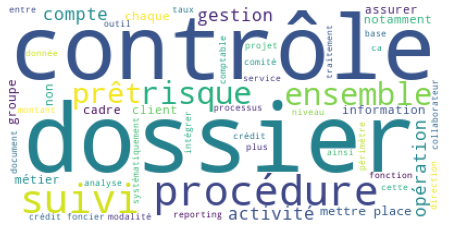

In [ ]:
wordcloud = WordCloud(background_color = 'white',  max_words = 50).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

In [ ]:
text_2009 = ""
for i in range (len(df_reco)):
    if df_reco.iloc[i]["annee"] == 2009:
        text_2009 += "".join(df_reco.iloc[i]['reco'])

In [ ]:
print(text_2009)

plus être tributaire emploi clé attente livraison datamart risques développer polyvalence travaux requêtes nécessaires constitution watch list augmenter capacité stockage espace métier direction risques car stade historiques conservés espaces personnels alternative peut consister stocker archives supports magnétiques indépendants tous cas solution sécurisée rechercherrédiger procédure élaboration gestion watch list spécifique opérations titrisationconformément manuel risques groupe définir procédure surveillance risques critères sortie watch list préciser systématiquement causes sortie états relatifs watch list mention critèresconformément normes groupe caisse epargne toper inscription watch list systèmes information plus différer développements informatiques correspondantsmettre place classification permettant introduire hiérarchisation niveau risques différentes lignes composant watch list ordre idée étudier intérêt créer hot list comme pratiqué autres établissements définir cas lesq

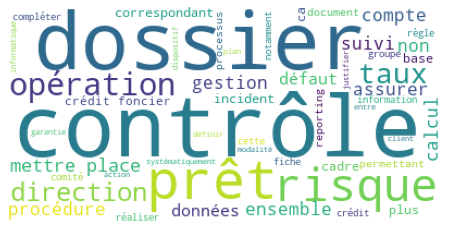

In [ ]:
wordcloud = WordCloud(background_color = 'white',  max_words = 50).generate(text_2009)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

***Malgré une surreprésentation des criticités P1 en 2009, l'ensemble des mots les plus présents dans l'ensemble des recommandations cette année est homogène à celui de l'ensemble des années.***

### Analyse fréquentielle des mots en fonction de la criticité

In [ ]:
text_P1 = ""
for i in range (len(df_reco)):
    if df_reco.iloc[i]["criticite"] == "P1":
        text_P1 += "".join(df_reco.iloc[i]['reco'])
text_P1 = text_P1.split()

text_P2 = ""
for i in range (len(df_reco)):
    if df_reco.iloc[i]["criticite"] == "P2":
        text_P2 += "".join(df_reco.iloc[i]['reco'])
text_P2 = text_P2.split()

text_P3 = ""
for i in range (len(df_reco)):
    if df_reco.iloc[i]["criticite"] == "P3":
        text_P3 += "".join(df_reco.iloc[i]['reco'])
text_P3 = text_P3.split()

In [ ]:
print(text_P1)

['mettre', 'œuvre', 'technologie', 'authentification', 'forte', 'type', 'orange', 'business', 'everywhere', 'accès', 'distance', 'autres', 'messageriemettre', 'place', 'dispositif', 'permettant', 'sécuriser', 'gestion', 'dossiers', 'copro', 'bailleurs', 'notamment', 'respect', 'délai', 'scrivener', 'respect', 'délai', 'rétractation', 'deux', 'mois', 'cohérence', 'entre', 'objet', 'prêt', 'figurant', 'contrat', 'prêt', 'réalité', 'financementprolongement', 'recommandation', 'déjà', 'émise', 'possiblimo', 'non', 'complètement', 'appropriée', 'faire', 'remonter', 'autorisation', 'directeur', 'engagements', 'régionalsimplifier', 'circuit', 'traitement', 'réclamations', 'liaison', 'métier', 'présenter', 'meilleurs', 'délais', 'nouveau', 'dispositif', 'interne', 'réseau', 'commercial', 'correspondantsdemander', 'direction', 'marketing', 'positionner', 'façon', 'accessible', 'informations', 'devant', 'être', 'obligatoirement', 'mises', 'disposition', 'clientèle', 'internet', 'cette', 'page', 

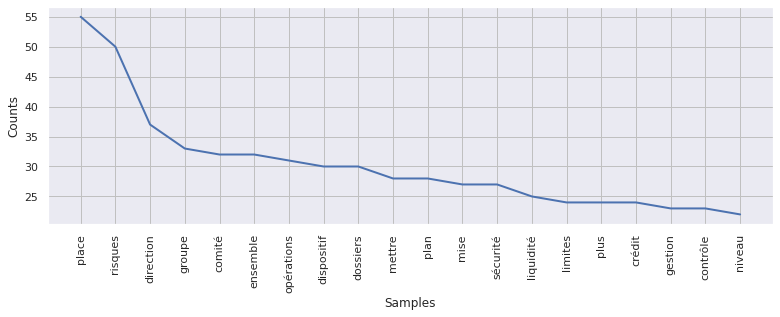

In [ ]:
sns.set_style('darkgrid')
nlp_words = nltk.FreqDist(text_P1)
nlp_words.plot(20);

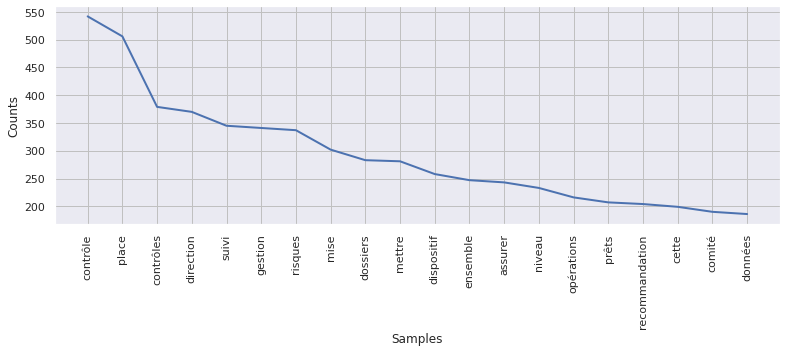

In [ ]:
nlp_words = nltk.FreqDist(text_P2)
nlp_words.plot(20);

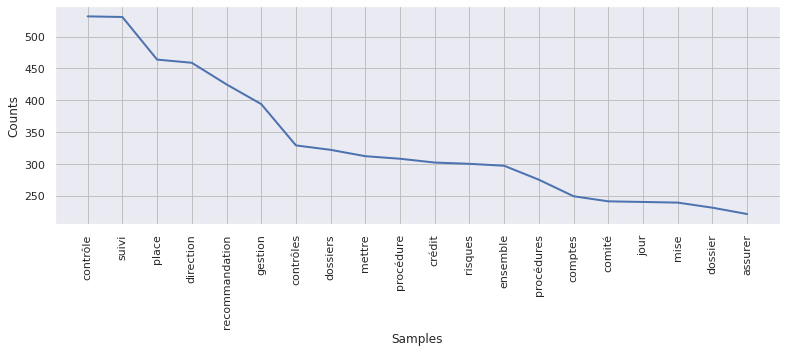

In [ ]:
nlp_words = nltk.FreqDist(text_P3)
nlp_words.plot(20);

On remarque que pour les trois types de criticités les mots surreprésentés sont souvent similaires. Cependant, leur position varie en fonction du type de criticité. 

En effet, on remarque par exemple que: 

-le mot "risques" est le mot le plus présent dans les recommandations P1, alors qu'il tombe à la quatrième place pour les recommandations P2 et ne fait pas partie des 20 mots les plus présents dans les recommandations P3. 

-le mot "suivi" est le mot le plus présent dans les recommandations P3, alors qu'il se trouve en sixième place des recommandations P2 et en quatorzième place des criticités P1.

-le verbe "assurer" est le quatorzième mot le plus représenté des criticités P2, alors qu'il ne fait pas partie des vingt mots les plus représentés des criticités P1 et P3. 

Ce sont très probablement ce genre de mots dont les réseaux de neuronnes se serviront pour classer les recommandations. 

Au contraire, on voit que les mots "place" et "contrôle" sont surreprésentés dans les trois types de criticités, ce qui ne fait pas d'eux des mots pertinents pour la classification.

# 3. Deep Learning

## 3.1. Data Structuring

In [ ]:
# Dataframe train/test/val = 70/20/10
train, test = train_test_split(df_reco, test_size = 0.1) 
train, val = train_test_split(train, test_size = 0.3)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4525 entries, 1492 to 248
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   annee      4525 non-null   int64 
 1   direction  4525 non-null   object
 2   origine    4525 non-null   object
 3   criticite  4525 non-null   object
 4   reco       4525 non-null   object
dtypes: int64(1), object(4)
memory usage: 212.1+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719 entries, 4824 to 589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   annee      719 non-null    int64 
 1   direction  719 non-null    object
 2   origine    719 non-null    object
 3   criticite  719 non-null    object
 4   reco       719 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.7+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719 entries, 4824 to 589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   annee      719 non-null    int64 
 1   direction  719 non-null    object
 2   origine    719 non-null    object
 3   criticite  719 non-null    object
 4   reco       719 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.7+ KB


### Functions

In [ ]:
#Simple Neural Networks

def get_criticites(df): #extract a list of each audit's level of criticality
    criticites=[]
    for i in range (len(df)):
        criticites.append(df.iloc[i]['criticite'])
    return criticites
    


def get_recos(df): #extract a list of each audit's recommendation (text)
    recos=[]
    for i in range (len(df)):
        recos.append(df.iloc[i]['reco'])
    return recos


def get_sequences(tokenizer, recos): #Cut the sequences to "maxlen" tokens and fill the shorter with zeros (if a sentence is shorter than maxlen => the padded sequence will end with zeros)
    sequences = tokenizer.texts_to_sequences(recos)
    padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen) #padding 0 in the end of each sequence until each sequence has maxlen elements
    return padded



#BERT 

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")

encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
        
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

### Parameters

In [ ]:
#word embedding
num_words = 10000
maxlen = 50 #Après distribution des mots étudiée
#LSTM
epochs = 20
patience = 3
#BERT 
n_epochs = 7

### Tokenization of the recommendations, creation of the vocabulary index based on word frequency

In [ ]:
tokenizer = Tokenizer(num_words, oov_token='<UNK>') #potentiellement changer num words
tokenizer.fit_on_texts(get_recos(train) + get_recos(val)) #Ajout des recos du validation set pour tokenizer. 
#Every word on recos gets a unique integer value (lower integer means more frequent word)

### Creation of a set of all of our labels, and a dictionary that we can use when converting our classes to their indexes and the indexes to classes.

In [ ]:
classes = set(get_criticites(train)) #defines the dict {'P2', 'P1', 'P3'}
class_to_index = dict((c,i) for i, c in enumerate(classes)) #{'P1': 0, 'P2': 2, 'P3': 1}
index_to_class = dict((v,k) for k, v in class_to_index.items()) #{0: 'P1', 1: 'P3', 2: 'P2'}
names_to_ids = lambda criticites: np.array([class_to_index.get(x) for x in criticites])

In [ ]:
print(classes), print(class_to_index), print(index_to_class)

{'P1', 'P2', 'P3'}
{'P1': 0, 'P2': 1, 'P3': 2}
{0: 'P1', 1: 'P2', 2: 'P3'}


(None, None, None)

### Splitting between levels of criticity and recommendations (we need all the recommendations to have the same length)

In [ ]:
#Have the same length => get_sequence

train_recos, train_criticites = get_recos(train),get_criticites(train)
train_seq = get_sequences(tokenizer, train_recos)
train_criticites = names_to_ids(train_criticites)

val_recos, val_criticites = get_recos(val),get_criticites(val)
val_seq = get_sequences(tokenizer, val_recos)
val_criticites = names_to_ids(val_criticites)

test_recos, test_criticites = get_recos(test), get_criticites(test)
test_seq = get_sequences(tokenizer, test_recos)
test_criticites = names_to_ids(test_criticites)

In [ ]:
#Example
train_seq[0]

array([ 166, 1496, 1018,  138,  495,  194,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
#Example
train_criticites[:10]

array([2, 2, 2, 1, 1, 1, 1, 2, 2, 1])

This shows that the first recommendation's class index, corresponding to its level of criticity 

## 3.2. Neural Networks

In [ ]:
word_index = tokenizer.word_index
print(len(word_index))

9375


### Perceptron

In [ ]:
model_p = MLPClassifier( activation = 'logistic', solver = 'adam') 
# logistic sigmoid function : f(x) = 1/(1+exp(-x))
# adam : stochastic gradient-based optimizer
print(model_p.get_params())


{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [ ]:
model_p.fit(train_seq, train_criticites)

model_p.score(test_seq, test_criticites)

50


0.5744089012517385

### Simple RNN

In [ ]:
model_RNN = tf.keras.models.Sequential([
tf.keras.layers.Embedding(len(word_index)+1,16,input_length=maxlen),
tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20, return_sequences=True)), 
tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20)), 
tf.keras.layers.Dense(3, activation='softmax') 
])

model_RNN.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model_RNN.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 16)            150016    
                                                                 
 bidirectional_30 (Bidirecti  (None, 50, 40)           1480      
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 40)               2440      
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 3)                 123       
                                                                 
Total params: 154,059
Trainable params: 154,059
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h_RNN = model_RNN.fit(train_seq, train_criticites,validation_data=(val_seq, val_criticites), epochs = 2 )



Epoch 1/2
142/142 [==============================] - 79s 539ms/step - loss: 0.7993 - accuracy: 0.5719 - val_loss: 0.7797 - val_accuracy: 0.5443
Epoch 2/2
142/142 [==============================] - 63s 440ms/step - loss: 0.6182 - accuracy: 0.7450 - val_loss: 0.8254 - val_accuracy: 0.5763


In [ ]:
model_RNN.evaluate(test_seq, test_criticites)

23/23 [==============================] - 1s 23ms/step - loss: 0.8860 - accuracy: 0.5675


[0.8860137462615967, 0.5674548149108887]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


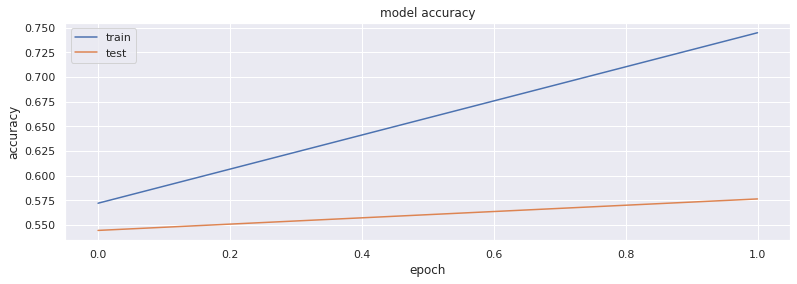

In [ ]:

# list all data in history
print(h_RNN.history.keys())
# summarize history for accuracy
plt.plot(h_RNN.history['accuracy'])
plt.plot(h_RNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LSTM Pour illustrer l'overfitting

In [ ]:
model_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Embedding(len(word_index) + 1,64,input_length=maxlen),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(3, activation='softmax')
])
model_LSTM.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model_LSTM.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 64)            600064    
                                                                 
 bidirectional_22 (Bidirecti  (None, 50, 40)           13600     
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 3)                 123       
                                                                 
Total params: 623,547
Trainable params: 623,547
Non-trainable params: 0
_________________________________________________________________


In [ ]:

h = model_LSTM.fit(
     train_seq, train_criticites,
     validation_data=(val_seq, val_criticites),
     epochs = 10
)


Epoch 1/10
142/142 [==============================] - 69s 66ms/step - loss: 0.8129 - accuracy: 0.5848 - val_loss: 0.7223 - val_accuracy: 0.6139
Epoch 2/10
142/142 [==============================] - 8s 53ms/step - loss: 0.6568 - accuracy: 0.6997 - val_loss: 0.7247 - val_accuracy: 0.6325
Epoch 3/10
142/142 [==============================] - 8s 54ms/step - loss: 0.4254 - accuracy: 0.8371 - val_loss: 0.8755 - val_accuracy: 0.6196
Epoch 4/10
142/142 [==============================] - 8s 53ms/step - loss: 0.2272 - accuracy: 0.9189 - val_loss: 1.0579 - val_accuracy: 0.6113
Epoch 5/10
142/142 [==============================] - 8s 53ms/step - loss: 0.1243 - accuracy: 0.9622 - val_loss: 1.4322 - val_accuracy: 0.5861
Epoch 6/10
142/142 [==============================] - 8s 54ms/step - loss: 0.0746 - accuracy: 0.9790 - val_loss: 1.5557 - val_accuracy: 0.5892
Epoch 7/10
142/142 [==============================] - 8s 54ms/step - loss: 0.0521 - accuracy: 0.9874 - val_loss: 1.7338 - val_accuracy: 0.596

In [ ]:
model_LSTM.evaluate(test_seq, test_criticites)

23/23 [==============================] - 0s 20ms/step - loss: 1.8195 - accuracy: 0.6287


[1.819453477859497, 0.6286509037017822]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


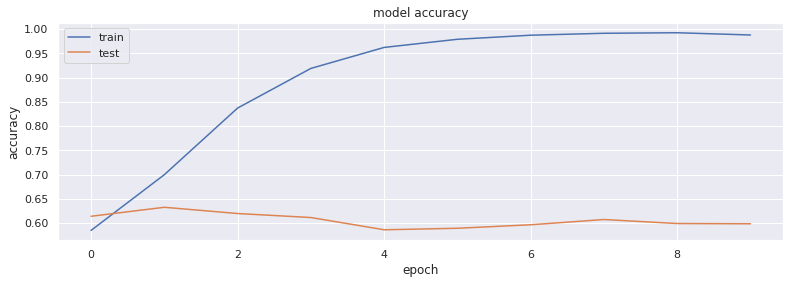

In [ ]:

# list all data in history
print(h.history.keys())
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

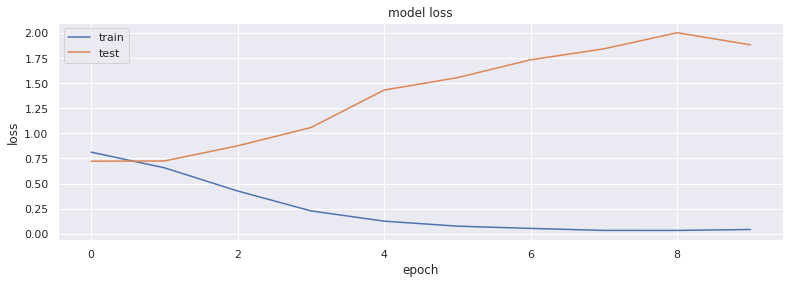

In [ ]:
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Vrai LSTM sur 2 epochs

In [ ]:
model_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Embedding(len(word_index) + 1,64,input_length=maxlen),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(3, activation='softmax')
])
model_LSTM.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)


h = model_LSTM.fit(
     train_seq, train_criticites,
     validation_data=(val_seq, val_criticites),
     epochs = 2
)
model_LSTM.evaluate(test_seq, test_criticites)

Epoch 1/2
142/142 [==============================] - 20s 66ms/step - loss: 0.8171 - accuracy: 0.5832 - val_loss: 0.7340 - val_accuracy: 0.6108
Epoch 2/2
23/23 [==============================] - 0s 20ms/step - loss: 0.7258 - accuracy: 0.6245


[0.7258397340774536, 0.6244784593582153]

### GRU

In [ ]:
model_GRU = tf.keras.models.Sequential([
tf.keras.layers.Embedding(len(word_index) + 1,16,input_length=maxlen),
tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20)),
tf.keras.layers.Dense(3, activation='softmax')
])
model_GRU.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model_GRU.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 50, 16)            150016    
                                                                 
 bidirectional_28 (Bidirecti  (None, 50, 40)           4560      
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 40)               7440      
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 3)                 123       
                                                                 
Total params: 162,139
Trainable params: 162,139
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h_GRU = model_GRU.fit(train_seq, train_criticites,
     validation_data=(val_seq, val_criticites),
     epochs = 2, 
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = patience)])

Epoch 1/2
142/142 [==============================] - 17s 64ms/step - loss: 0.8282 - accuracy: 0.5728 - val_loss: 0.7583 - val_accuracy: 0.5938
Epoch 2/2
142/142 [==============================] - 7s 53ms/step - loss: 0.7468 - accuracy: 0.6201 - val_loss: 0.7216 - val_accuracy: 0.6191


In [ ]:
model_GRU.evaluate(test_seq, test_criticites)

23/23 [==============================] - 0s 20ms/step - loss: 0.7233 - accuracy: 0.6314


[0.723300576210022, 0.6314325332641602]

### Bert

In [ ]:
# map topic descriptions to labels
df = df_reco.copy()
df['labels'] = df_reco['criticite'].map({'P1': 0,
                                            'P2': 1,
                                            'P3': 2,
                                            })

df.head()

In [ ]:
y = tf.keras.utils.to_categorical(df["labels"].values, num_classes=3)

x_train, x_test, y_train, y_test = train_test_split(df['reco'], y, test_size=0.25)

In [ ]:
get_embeddings([
    "commissionnement convention signée régissant notamment commissionnement titre prêts structurés plus valide depuis signer nouvelle convention"]
)

In [ ]:
reviews = ["le livre est intéressant",
           "le roman est intéressant",
           "au milieu du voyage de notre vie"]

plot_similarity(get_embeddings(reviews), reviews)

In [ ]:
reviews = ["I Pink Floyd sono stati un gruppo rock britannico, fondato a Londra nel 1965",
           "Pink Floyd were an English rock band formed in London in 1965",
           "In mathematics, a theorem is a statement that has been proved, or can be proved."]

plot_similarity(get_embeddings(reviews), reviews)

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')


preprocessor = hub.load(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")

# Step 1: tokenize batches of text inputs.
text_inputs = [i] # This SavedModel accepts up to 2 text inputs.
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]


# Step 2: pack input sequences for the Transformer encoder.
seq_length = 100  # Choix fait après analyse des distributions des mots
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)



x = encoder(encoder_inputs)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(3, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

In [ ]:

x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
model_fit.evaluate(test_seq, test_criticites)

## ESSAI sur P1P2-P3

### Data structuring

In [ ]:
# map topic descriptions to labels
df = df_reco_P1P2.copy()
df['labels'] = df['criticite'].map({'P1P2': 0,
                                            'P3': 1,
                                            })
df.head()

,annee,direction,origine,criticite,reco,labels
0,2010,Direction Générale,CFF,P1P2,commissionnement convention signée régissant n...,0
1,2010,Socfim,CFF,P1P2,séparation fonctions attribuer back office tâc...,0
2,2010,Socfim,CFF,P3,indicateur gestion etablir statistiques suivi ...,1
3,2010,Socfim,CFF,P1P2,procédures bo rédiger procédures bo faisant re...,0
4,2010,Inspection Générale,CFF,P3,calcul risque immobilier pvh constituer histor...,1


In [ ]:
# Dataframe train/test/val = 70/20/10
trainbis, testbis = train_test_split(df_reco_P1P2, test_size = 0.1) 
trainbis, valbis = train_test_split(trainbis, test_size = 0.3)

classesP1P2 = set(get_criticites(trainbis)) #defines the dict {'P1P2', 'P3'}
class_to_indexP1P2 = dict((c,i) for i, c in enumerate(classesP1P2)) #{'P1P2': 0, 'P3': 1}
index_to_classP1P2 = dict((v,k) for k, v in class_to_indexP1P2.items()) 
names_to_idsP1P2 = lambda criticites: np.array([class_to_indexP1P2.get(x) for x in criticites])
print(classesP1P2), print(class_to_indexP1P2), print(index_to_classP1P2)


{'P1P2', 'P3'}
{'P1P2': 0, 'P3': 1}
{0: 'P1P2', 1: 'P3'}


(None, None, None)

In [ ]:
#Have the same length => get_sequence

train_recosbis, train_criticitesbis = get_recos(trainbis),get_criticites(trainbis)
train_seqbis = get_sequences(tokenizer, train_recosbis)
train_criticitesbis = names_to_idsP1P2(train_criticitesbis)

val_recosbis, val_criticitesbis = get_recos(valbis),get_criticites(valbis)
val_seqbis = get_sequences(tokenizer, val_recosbis)
val_criticitesbis = names_to_idsP1P2(val_criticitesbis)

test_recosbis, test_criticitesbis = get_recos(testbis), get_criticites(testbis)
test_seqbis = get_sequences(tokenizer, test_recosbis)
test_criticitesbis = names_to_idsP1P2(test_criticitesbis)

### MLP

In [ ]:
model_p_bin = MLPClassifier( activation = 'logistic', solver = 'adam') 
model_p_bin.fit(train_seqbis, train_criticitesbis)

model_p_bin.score(test_seqbis, test_criticitesbis)

0.5799721835883171

### RNN

In [ ]:
def trouver_epoch_RNN(epoch):
    resultat = 0
    ep = 0
    for i in range (1,epoch+1):
        model_RNN_bin = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(word_index)+1,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20, return_sequences=True)), #
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20)), #
        tf.keras.layers.Dense(1, activation='sigmoid') #
        ])

        model_RNN_bin.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        
        h_RNN_bin = model_RNN_bin.fit(train_seqbis, train_criticitesbis,validation_data=(val_seqbis, val_criticitesbis), epochs = i )

        performance = model_RNN_bin.evaluate(test_seqbis, test_criticitesbis)[1]
        if performance > resultat:
            resultat = performance
            ep = i
    return ep, resultat


In [ ]:
print(trouver_epoch_RNN(4))

23/23 [==============================] - 1s 48ms/step - loss: 0.6472 - accuracy: 0.6259
Epoch 1/2
142/142 [==============================] - 66s 421ms/step - loss: 0.6722 - accuracy: 0.5905 - val_loss: 0.6558 - val_accuracy: 0.6149
Epoch 2/2
 67/142 [=============>................] - ETA: 19s - loss: 0.5415 - accuracy: 0.7444

KeyboardInterrupt: ignored

Le meilleur résultat est pour 1 epoch. On entraîne donc un modèle sur ce nombre d'epoch pour le tester sur les recos de la BCE.

In [ ]:
model_RNN_bin = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(word_index)+1,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20, return_sequences=True)), 
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(20)), 
        tf.keras.layers.Dense(1, activation='sigmoid') 
        ])

model_RNN_bin.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
h_RNN_bin = model_RNN_bin.fit(train_seqbis, train_criticitesbis,validation_data=(val_seqbis, val_criticitesbis), epochs = 1 )

142/142 [==============================] - 53s 335ms/step - loss: 0.6710 - accuracy: 0.5947 - val_loss: 0.6568 - val_accuracy: 0.6180


### LSTM

In [ ]:
def trouver_epoch_LSTM(epoch):
    resultat = 0
    ep = 0
    for i in range (1,epoch+1):
        model_LSTM_bin = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(word_index) + 1,64,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model_LSTM_bin.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        
        h_LSTM_bin = model_LSTM_bin.fit(
            train_seqbis, train_criticitesbis,
            validation_data=(val_seqbis, val_criticitesbis),
            epochs = i,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = patience)]
        )
        performance = model_LSTM_bin.evaluate(test_seqbis, test_criticitesbis)[1]
        if performance > resultat:
            resultat = performance
            ep = i
    return ep, resultat


In [ ]:
print(trouver_epoch_LSTM(5))

Le meilleur résultat est pour 2 epochs. On entraîne donc un modèle sur ce nombre d'epoch pour le tester sur les recos de la BCE.

In [ ]:
model_LSTM_bin = tf.keras.models.Sequential([
tf.keras.layers.Embedding(len(word_index) + 1,64,input_length=maxlen),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(1, activation='sigmoid')
])
model_LSTM_bin.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
h_LSTM_bin = model_LSTM_bin.fit(
    train_seqbis, train_criticitesbis,
    validation_data=(val_seqbis, val_criticitesbis),
    epochs = 2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = patience)]
)

Epoch 1/2
142/142 [==============================] - 20s 88ms/step - loss: 0.6643 - accuracy: 0.6009 - val_loss: 0.6111 - val_accuracy: 0.6691
Epoch 2/2
142/142 [==============================] - 9s 60ms/step - loss: 0.4985 - accuracy: 0.7591 - val_loss: 0.6465 - val_accuracy: 0.6485


### GRU

In [ ]:
def trouver_epoch_GRU(epoch):
    resultat = 0
    ep = 0
    for i in range (1,epoch+1):
        model_GRU_bin = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(word_index) + 1,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20)),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model_GRU_bin.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        h_GRU_bin = model_GRU_bin.fit(train_seqbis, train_criticitesbis,
            validation_data=(val_seqbis, val_criticitesbis),
            epochs = i, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = patience)])
        
        performance = model_GRU_bin.evaluate(test_seqbis, test_criticitesbis)[1]
        if performance > resultat:
            resultat = performance
            ep = i
    return ep, resultat



In [ ]:
print(trouver_epoch_GRU(5))


Le meilleur résultat est pour 1 epoch. On entraîne donc un modèle sur ce nombre d'epoch pour le tester sur les recos de la BCE.

In [ ]:
model_GRU_bin = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_GRU_bin.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
h_GRU_bin = model_GRU_bin.fit(train_seqbis, train_criticitesbis,
    validation_data=(val_seqbis, val_criticitesbis),
    epochs = 1)

142/142 [==============================] - 17s 72ms/step - loss: 0.6762 - accuracy: 0.5761 - val_loss: 0.6407 - val_accuracy: 0.6278


### Bert

In [ ]:
y = tf.keras.utils.to_categorical(df["labels"].values, num_classes=2)

x_train, x_test, y_train, y_test = train_test_split(df['reco'], y, test_size=0.25)

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')


preprocessor = hub.load(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")

# Step 1: tokenize batches of text inputs.
text_inputs = [i] # This SavedModel accepts up to 2 text inputs.
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]


# Step 2: pack input sequences for the Transformer encoder.
seq_length = 100  # Choix fait après analyse des distributions des mots
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)



x = encoder(encoder_inputs)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(2, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = 2,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

In [ ]:

x = list(range(1, 2+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

# Test base BCE

## Création des bases P1-P2-P3 et P1P2-P3

In [ ]:
base_bce = './base_finale_bce.csv'
df_base_bce= pd.read_csv(base_bce)

In [ ]:
df_base_bce.tail()

,libelle,reference,annee,exclusion,criticite,origine,date_envoi_rapport,direction,Recommandation
690,2015-083 - Contrôleur Spécifique,CFF-2015-011-R004,2015,0,P2,BCE,2015-06-10,Direction Financière,Intégrer dans les calculs des reportings régl...
691,2015-085 - CAC CFF_31 décembre 2015,CFF-2015-016-R001,2015,0,P2,BCE,2016-02-10,Direction Financière,Tirer les conséquences comptables de l’absenc...
692,2016-083 - CAC Locindus_30 juin 2016,CFF-2016-005-R001,2016,0,P3,BCE,2016-08-23,Direction Opérations Corporates,Réaliser une revue de tous les prêts en direc...
693,2016-084 - CAC BancoPrimus_30_juin_2016,CFF-2015-017-R001,2016,1,P3,BCE,2016-06-30,Banco Primus,Política e Procedimentos - Scoring Clientes A...
694,2016-086 - Loi SRAB,BPCE-2015-059-R005,2016,0,P1,BCE,2016-06-01,Direction Risques et Conformité,Identifier au sein du Groupe Crédit Foncier d...


In [ ]:
# lower case
df_base_bce['reco'] = df_base_bce['Recommandation'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Suppression ponctuation et stop words, puis des chiffres ou des mots d'une lettre
df_base_bce.reco = df_base_bce.reco.apply(lambda x: regex1.sub(" ",x))
df_base_bce.reco = df_base_bce.reco.apply(lambda x: regex2.sub(" ",x))
df_base_bce.reco = df_base_bce.reco.apply(lambda x: regex3.sub(" ",x))

df_base_bce.reco = df_base_bce.reco.apply(lambda x: " ".join(x for x in x.split() if x not in stop_s))

In [ ]:
df_bce_P1P2 = df_base_bce
df_bce_P1P2 = df_bce_P1P2.replace({'P1': 'P1P2', 'P2': 'P1P2'})

In [ ]:
df_bce_P1P2.head()

,libelle,reference,annee,exclusion,criticite,origine,date_envoi_rapport,direction,Recommandation,reco
0,ACP - Lettre de cadrage Nouy 2012,BPCE-2012-ME051-R003,2012,0,P1P2,BCE,01/06/2012,Direction Risques et Conformité,Accélérer la mise en œuvre du plan de recentra...,accélérer mise œuvre plan recentrage stratégiq...
1,ACP - Lettre de cadrage Nouy 2012,BPCE-2012-ME051-R004,2012,0,P1P2,BCE,01/06/2012,Direction Risques et Conformité,Poursuivre les efforts de diversification du r...,poursuivre efforts diversification refinanceme...
2,ACP - Lettre de cadrage Nouy 2012,BPCE-2012-ME051-R009,2012,0,P1P2,BCE,01/06/2012,Direction Risques et Conformité,En termes de trajectoires de solvabilité s'as...,termes trajectoires solvabilité assurer hypoth...
3,ACP - Lettre de cadrage Nouy 2012,BPCE-2012-ME051-R017,2012,0,P1P2,BCE,01/06/2012,Direction Risques et Conformité,Suivre de manière rapprochée les risques de cr...,suivre manière rapprochée risques crédit détec...
4,ACP - Lettre de cadrage annuelle D.NOUY 2013,BPCE-2013-ME051-R002,2013,0,P1P2,BCE,01/03/2013,Direction Générale,Poursuivre la politique volontariste de cessio...,poursuivre politique volontariste cession acti...


## Data structuring

In [ ]:


bce_recos, bce_criticites = get_recos(df_base_bce),get_criticites(df_base_bce)
bce_seq = get_sequences(tokenizer, bce_recos)
bce_criticites = names_to_ids(bce_criticites)


bce_recos_bin, bce_criticites_bin = get_recos(df_bce_P1P2),get_criticites(df_bce_P1P2)
bce_seq_bin = get_sequences(tokenizer, bce_recos_bin)
bce_criticites_bin = names_to_idsP1P2(bce_criticites_bin)

## Test P1-P2-P3

In [ ]:
model_p.score(bce_seq, bce_criticites)

0.3553956834532374

In [ ]:
model_RNN.evaluate(bce_seq, bce_criticites)

22/22 [==============================] - 1s 54ms/step - loss: 1.2751 - accuracy: 0.4763


[1.2750695943832397, 0.4762589931488037]

In [ ]:
model_LSTM.evaluate(bce_seq, bce_criticites)

22/22 [==============================] - 0s 20ms/step - loss: 1.2368 - accuracy: 0.4993


[1.2367764711380005, 0.49928057193756104]

In [ ]:
model_GRU.evaluate(bce_seq, bce_criticites)

22/22 [==============================] - 0s 20ms/step - loss: 1.3437 - accuracy: 0.4561


[1.3436729907989502, 0.45611509680747986]

## Test P1P2-P3

In [ ]:
model_p_bin.score(bce_seq_bin, bce_criticites_bin)

0.5050359712230216

In [ ]:
model_RNN_bin.evaluate(bce_seq_bin, bce_criticites_bin)

NameError: ignored

In [ ]:
model_LSTM_bin.evaluate(bce_seq_bin, bce_criticites_bin)

22/22 [==============================] - 0s 19ms/step - loss: 0.6147 - accuracy: 0.6432


[0.6146909594535828, 0.6431654691696167]

In [ ]:
model_GRU_bin.evaluate(bce_seq_bin, bce_criticites_bin)

22/22 [==============================] - 0s 20ms/step - loss: 0.7749 - accuracy: 0.4173


[0.7748727202415466, 0.41726619005203247]